In [6]:
from bitarray import bitarray
from hashlib import sha3_256,sha256, blake2b
from string import ascii_letters,ascii_lowercase
import matplotlib.pyplot as plt
import numpy as np
import json

class bloom_filter:
    '''
    initialization: input bloom filter size and the number of hash functions.
    add():insert words in the filter
    check():determine whether the word is in the filter
    '''
    def __init__(self,size,hash_k=3) -> None:
        self.size=int(size)
        self.hash_k=int(hash_k)
        self.__data=bitarray(self.size)
        self.__hash_list=[self.__my_hash1,self.__my_hash2,self.__my_hash3][:self.hash_k]

        self.__data.setall(0)

    def __my_hash1(self,s):
        return int( sha256(s. lower() .encode()). hexdigest(), 16) % self.size
    def __my_hash2(self,s):
        return int( blake2b(s. lower() .encode()). hexdigest(), 16) % self.size
    def __my_hash3(self,s):
        return int( sha3_256(s. lower() .encode()). hexdigest(), 16) % self.size

    def add(self,word):
        p=[hash_func(word) for hash_func in self.__hash_list]
        for i in p:
            self.__data[i]=1

    def check(self,word):
        p=[hash_func(word) for hash_func in self.__hash_list]
        in_bf=0
        for i in p:
            if self.__data[i]==1:
                in_bf+=1
        if in_bf==self.hash_k:
            return True
        else:
            return False

    def show(self):
        print(self.__data)

    def spelling_suggest(self,word):
        '''return word suggestions by letter substitution'''
        words_possible=[]
        for letter in range(len(word)):
            front=word[:letter]
            later=word[letter+1:]
            words_substite=[f'{front}{i}{later}' for i in ascii_lowercase.replace(word[letter],'')]
            for w in words_substite:
                if self.check(w):
                    words_possible.append(w)
        return words_possible

    def spelling_correction(self,word):
        suggest_words=self.spelling_suggest(word)
        if self.check(word):
            suggest_words=[word]+suggest_words
        return suggest_words

In [7]:
size=1e7
hash_k=3
bf3=bloom_filter(size,hash_k)
with open(r'words.txt') as f:
    for line in f:
        word=line.strip()
        bf3.add(word)
inword=['2','1080','&c','10-point'] #This is the top4 words in the words.txt
for item in inword:
    print(bf3.check(item))
#This is my name and it is not in the words.txt
print(bf3.check('Heyuan'))

True
True
True
True
False


In [8]:
for hash_k in [1,2,3]:
    bf=bloom_filter(size,hash_k)
    with open(r'words.txt') as f:
        for line in f:
            word=line.strip()
            bf.add(word)
    print('Whether the filter contains floeer:',bf.check('floeer'))
    print('suggestions using the %s hash function:'%['first','first and second','all'][hash_k-1])
    words_possible=bf.spelling_correction('floeer')
    print(words_possible)

Whether the filter contains floeer: False
suggestions using the first hash function:
['bloeer', 'qloeer', 'fyoeer', 'flofer', 'floter', 'flower', 'floeqr', 'floees']
Whether the filter contains floeer: False
suggestions using the first and second hash function:
['fyoeer', 'floter', 'flower']
Whether the filter contains floeer: False
suggestions using the all hash function:
['floter', 'flower']


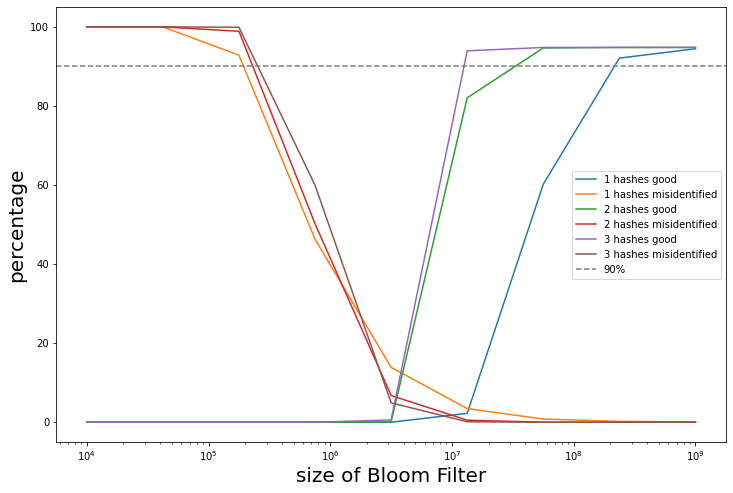

[[0.0, 0.0, 0.0, 0.0, 0.0, 2.252, 60.224, 92.104, 94.472], [0.0, 0.0, 0.0, 0.0, 0.076, 82.06, 94.676, 94.796, 94.808], [0.0, 0.0, 0.0, 0.0, 0.588, 93.948, 94.796, 94.808, 94.808]]
[[100.0, 99.996, 92.83200000000001, 46.288000000000004, 13.876, 3.4479999999999995, 0.808, 0.212, 0.052], [100.0, 100.0, 98.892, 50.192, 6.755999999999999, 0.508, 0.02, 0.0, 0.0], [100.0, 100.0, 99.908, 59.952000000000005, 4.9, 0.116, 0.0, 0.0, 0.0]]
[1.00000000e+04 4.21696503e+04 1.77827941e+05 7.49894209e+05
 3.16227766e+06 1.33352143e+07 5.62341325e+07 2.37137371e+08
 1.00000000e+09]


In [10]:
'''plot good_rate and mis_rate in one plot'''
with open(r'typos.json') as f:
    data=json.loads(f.read())

N=np.logspace(4,9,9)
plt.figure(figsize=(12,8))
plt.axes(xscale='log')
plt.xlabel('size of Bloom Filter',fontsize=20)
plt.ylabel('percentage',fontsize=20)
good_rate_N_k=[]
mis_rate_N_k=[]
for hash_k in [1,2,3]:
    good_rate_N=[]
    mis_rate_N=[]
    for size in N:
        bf=bloom_filter(size,hash_k)
        with open(r'words.txt') as f:
            for line in f:
                word=line.strip()
                bf.add(word)
        good_suggestion=0
        misidentified=0
        for pair in data:
            if bf.check(pair[0]) and pair[0]!=pair[1]:
                misidentified+=1
            suggest_words=bf.spelling_suggest(pair[0])
            if pair[1] in suggest_words:
                if len(suggest_words)<4:
                    good_suggestion+=1
        good_rate=good_suggestion/len(data)*2
        mis_rate=misidentified/len(data)*2
        good_rate_N.append(good_rate*100)
        mis_rate_N.append(mis_rate*100)
    plt.plot(N, good_rate_N, label='%d hashes good'%hash_k)
    plt.plot(N, mis_rate_N,label='%d hashes misidentified'%hash_k)
    good_rate_N_k.append(good_rate_N)
    mis_rate_N_k.append(mis_rate_N)

plt.axhline(y=90,color='gray',linestyle='dashed',label='90%')
plt.legend()
plt.savefig('good_mis_rate.jpg')
plt.show()
print(good_rate_N_k)
print(mis_rate_N_k)
print(N)